# ALGOMED

## <ins>Preparation</ins>

### Importing pandas and loading the datasets

In [86]:
import pandas as pd

print('Loading data...')
df_drugs = pd.read_csv('drugs_data.csv')
print('\n ** df_drugs loaded **')
print(df_drugs.loc[:4, ['cis', 'name', 'se_fever', 'se_diarrhea', 'ci_disease_0']])
df_patients = pd.read_csv('patients_data.csv')
print('\n ** df_patients loaded **')
print(df_patients.loc[:5, ['nss', 'age', 'sex', 'weight', 'hc_smoke']])
df_treatments = pd.read_csv('treatments_data.csv')
print('\n ** df_treatments loaded **')
print(df_treatments.loc[:5, ['starting_date', 'disease', 'patient_feedback', 'type']])
print('\n Data loaded.')

Loading data...

 ** df_drugs loaded **
   cis                       name  se_fever  se_diarrhea  ci_disease_0
0    0           DOLIPRANE 500 mg         0            0             0
1    1          GLUCOPHAGE 500 mg         0            1             0
2    2  ATORVASTATINE MYLAN 10 mg         1            1             1
3    3  IBUPROFéNE VIATRIS 400 mg         0            0             0

 ** df_patients loaded **
   nss  age  sex  weight  hc_smoke
0    2   40    1      54         0
1    4   38    1      74         0
2   10   40    1      70         0
3    5   34    1      45         0
4    5   29    1      52         0
5    7   32    1      42         0

 ** df_treatments loaded **
  starting_date           disease  patient_feedback             type
0    01/02/2022  vagal_discomfort               0.8             drug
1    04/12/2018     heart_desease               0.4             drug
2    04/02/2022  vagal_discomfort               0.7             drug
3    12/12/1999     heart_de

### Preparing and cleaning the data

In [42]:
df_drugs = df_drugs.set_index('cis')
df_patients = df_patients.set_index('nss')
df_treatments = df_treatments.set_index('id')
print('Data cleaned.')

Data cleaned.


## <ins>Micro-service 1 - Treatment scoring</ins>

### Compute the scoring for the existing data

In [46]:
import math

history_score_weights = {'drugs': 0.2, 'hospitalizations': 0.8}
treatment_efficiency_weights = {'patient_feedback': 0.15, 'pharmacist_feedback': 0.15, 'history_efficiency': 0.7}
scoring_weights = {'fever_scoring': 0.15, 'diarrhea_scoring': 0.15, 'efficiency': 0.7}

def compute_treatment_history_score(df_post_events):
    nb_followup_drugs = df_post_events[df_post_events.type == 'drug'].shape[0]
    nb_followup_hospitalizations = df_post_events[df_post_events.type == 'hospitalization'].shape[0]
    history_efficiency = math.exp(-nb_followup_drugs*history_score_weights['drugs']
               - nb_followup_hospitalizations*history_score_weights['hospitalizations'])
    return(nb_followup_drugs,nb_followup_hospitalizations,history_efficiency)

def compute_treatment_efficiency(treatment):
    treatment.efficiency = treatment.patient_feedback*treatment_efficiency_weights['patient_feedback'] + treatment.pharmacist_feedback*treatment_efficiency_weights['pharmacist_feedback'] + treatment.history_efficiency*treatment_efficiency_weights['history_efficiency']
    return treatment

def compute_treatment_scoring(treatment):
    treatment.scoring = treatment.fever_scoring*scoring_weights['fever_scoring'] + treatment.diarrhea_scoring*scoring_weights['diarrhea_scoring'] + treatment.efficiency*scoring_weights['efficiency']
    return treatment

In [47]:
df_treatments_output = df_treatments.copy()
df_treatments_output['history_efficiency'] = 0
df_treatments_output['nb_followup_drugs'] = 0
df_treatments_output['nb_followup_hospitalizations'] = 0
df_treatments_output['efficiency'] = 0
df_treatments_output['scoring'] = 0
def compute_scoring(df, nss = None):
    for i in range(df.shape[0]):
        if((nss != None) and (nss != df.loc[i, 'nss'])):
            continue
        df_post_events = df[(df_treatments_output['starting_date'] > df.loc[i, 'starting_date']) & (df['nss'] == df.loc[i, 'nss'])]
        nb_followup_drugs,nb_followup_hospitalizations, history_efficiency = compute_treatment_history_score(df_post_events)
        df.loc[i, 'nb_followup_drugs'] = nb_followup_drugs
        df.loc[i, 'nb_followup_hospitalizations'] = nb_followup_hospitalizations
        df.loc[i, 'history_efficiency'] = history_efficiency
    df_with_results = df.apply(compute_treatment_efficiency, axis='columns').apply(compute_treatment_scoring, axis='columns')
    return(df_with_results)
df_with_results = compute_scoring(df_treatments_output)

print('#######')
print('Treatment 1')
print(df_with_results.loc[0, ['nss', 'nb_followup_drugs', 'nb_followup_hospitalizations', 'patient_feedback', 'pharmacist_feedback', 'fever_scoring', 'diarrhea_scoring', 'efficiency', 'scoring']])
print('\n')
print('#######')
print('Treatment 2')
print(df_with_results.loc[1, ['nss', 'nb_followup_drugs', 'nb_followup_hospitalizations', 'patient_feedback', 'pharmacist_feedback', 'fever_scoring', 'diarrhea_scoring', 'efficiency', 'scoring']])
print('#######')
print('Treatment 3')
print(df_with_results.loc[2, ['nss', 'nb_followup_drugs', 'nb_followup_hospitalizations', 'patient_feedback', 'pharmacist_feedback', 'fever_scoring', 'diarrhea_scoring', 'efficiency', 'scoring']])

#######
Treatment 1
nss                                 0
nb_followup_drugs                   0
nb_followup_hospitalizations        0
patient_feedback                  0.8
pharmacist_feedback               1.0
fever_scoring                     0.5
diarrhea_scoring                    0
efficiency                       0.97
scoring                         0.754
Name: 0, dtype: object


#######
Treatment 2
nss                                 1
nb_followup_drugs                   0
nb_followup_hospitalizations        0
patient_feedback                  0.4
pharmacist_feedback               0.4
fever_scoring                     0.0
diarrhea_scoring                    0
efficiency                       0.82
scoring                         0.574
Name: 1, dtype: object
#######
Treatment 3
nss                                    1
nb_followup_drugs                      1
nb_followup_hospitalizations           0
patient_feedback                     0.7
pharmacist_feedback                  1.0
fev

### Scoring update

In [7]:
## We should have API calls and webhooks to trigger updates from the 'Dossier Patient'
## When an hook is triggered, we re-computing the scoring for this specific patient (i.e. patient_id)
nss = 1
#compute_scoring(df_treatments, nss)

## <ins>Micro-service 2 - Recommandation</ins>

### First step - Detect anomalis (simple heuristic)

In [102]:
nss = 1
treatment_id = 1
patient = df_patients.iloc[nss, :]
treatment = df_with_results.iloc[treatment_id,:]
associated_drug = df_drugs.iloc[treatment.drug, :]
deseases_map = {0: 'vagal_discomfort', 1: 'diabetes', 2: 'heart_desease'}

def compute_patient_drugs():
    return(df_with_results[df_with_results['nss'] == nss]['drug'].unique())

def compute_notable_side_effects():
    notable_side_effects = []
    if(associated_drug['se_fever'] == 1):
        notable_side_effects.append('Can create fever for the patient.')
    if(associated_drug['se_diarrhea'] == 1):
        notable_side_effects.append('Can create diarrhea for the patient.')
    return(notable_side_effects)

def compute_counter_indications():
    counter_indications = []
    patient_drugs = compute_patient_drugs()
    if(associated_drug['ci_woman'] == 1 and patient['sex'] == 0):
        counter_indications.append('Not recommanded for women (the patient is a woman).')
    if(associated_drug['ci_man'] == 1 and patient['sex'] == 1):
        counter_indications.append('Not recommanded for men (the patient is a man).')
    if(associated_drug['ci_child'] == 1 and patient['age'] < 18):
        counter_indications.append('Not recommanded for children (the patient is a ' + str(patient['age']) + ').')
    if(associated_drug['ci_pregnant'] == 1 and patient['hc_pregnant'] == True):
        counter_indications.append('Not recommanded for pregnant women (the patient is pregnant).')
    if(associated_drug['ci_disease_0'] == 1 and patient['disease_0'] == 1):
        counter_indications.append('Not recommanded for people having ' + deseases_map[0])
    if(associated_drug['ci_disease_1'] == 1 and patient['disease_1'] == 1):
        counter_indications.append('Not recommanded for people having ' + deseases_map[1])
    if(associated_drug['ci_disease_2'] == 1 and patient['disease_2'] == 1):
        counter_indications.append('Not recommanded for people having ' + deseases_map[2])
    if(associated_drug['ci_drug_0'] == 1 and 0 in patient_drugs):
        counter_indications.append('Not recommanded for people with treatment ' + df_drugs.loc[0, 'name'])
    if(associated_drug['ci_drug_1'] == 1 and 1 in patient_drugs):
        counter_indications.append('Not recommanded for people with treatment ' + df_drugs.loc[1, 'name'])
    if(associated_drug['ci_drug_2'] == 1 and 2 in patient_drugs):
        counter_indications.append('Not recommanded for people with treatment ' + df_drugs.loc[2, 'name'])
    if(associated_drug['ci_drug_3'] == 1 and 3 in patient_drugs):
        counter_indications.append('Not recommanded for people with treatment ' + df_drugs.loc[3, 'name'])
    return(counter_indications)

def general_scan_output():
    print('##############')
    print('Assessing feasability of patient 16XFV65')
    print('for medicine ' + df_drugs.loc[treatment['drug'], 'name'] + '...')
    print('\n')
    print("\033[4mPosology.\033[0m")
    print(str(associated_drug['do_quantity'] * patient['weight']) + 'mg (patient is ' + str(patient['weight']) + ' kg, recommanded dose is ' + str(associated_drug['do_quantity']) + 'mg/kg),')
    print(str(associated_drug['do_frequency']) + ' times per day, during ' + str(associated_drug['do_duration']) + ' days')
    print('\n')
    print("\033[4mSide effects.\033[0m")
    notable_side_effects = compute_notable_side_effects()
    if(len(notable_side_effects) == 0):
        print('None.')
    else:
        for side_effect in notable_side_effects:
            print(side_effect)
    print('\n')
    print("\033[4mIncompatibilities for the current patient.\033[0m")
    counter_indications = compute_counter_indications()
    if(len(counter_indications) == 0):
        print('None.')
    else:
        for counter_indication in counter_indications:
            print(counter_indication)
    print('\n')
    print('Assessment finished.')
    print('##############')
general_scan_output()

##############
Assessing feasability of patient 16XFV65
for medicine ATORVASTATINE MYLAN 10 mg...


Posology.
74mg (patient is 74 kg, recommanded dose is 1mg/kg),
2 times per day, during 2 days


Side effects.
Can create fever for the patient.
Can create diarrhea for the patient.


Incompatibilities for the current patient.
Not recommanded for men (the patient is a man).


Assessment finished.
##############


### Second step - Compute the neareast neightboors

In [105]:
# Importing scikit-learn
from sklearn.neighbors import NearestNeighbors
import numpy as np
nb_neighbors = 10
X = df_patients.loc[:, ['age', 'sex', 'weight', 'hc_pregnant']].to_numpy()
nbrs = NearestNeighbors(n_neighbors=nb_neighbors, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
print("#########")
print('Nearest neighbors...')
print(nbrs.kneighbors_graph(X).toarray()[:5])

#########
Nearest neighbors...
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [95]:
from pyvis.network import Network
import networkx as nx
df = pd.DataFrame(nbrs.kneighbors_graph(X).toarray())
net = nx.Graph()
for i in range(df.shape[0]):
    age = df_patients.loc[i, 'age']
    if ( age < 20):
        color = '#3393FF'
    elif ( age < 50):
        color = '#2FC31E'
    else :
        color = '#9122EC'
    net.add_node(i, label="Patient " + str(i), color= color)
for i in range(df.shape[0]):
    for j in range(df.shape[0]):
        if (df[i][j] == 1 and i != j):
            net.add_edge(i, j, weight=1)
nt = Network('800px', '1200px')
nt.from_nx(net)
nt.show('nx.html')
print('Graph edited')

Graph edited


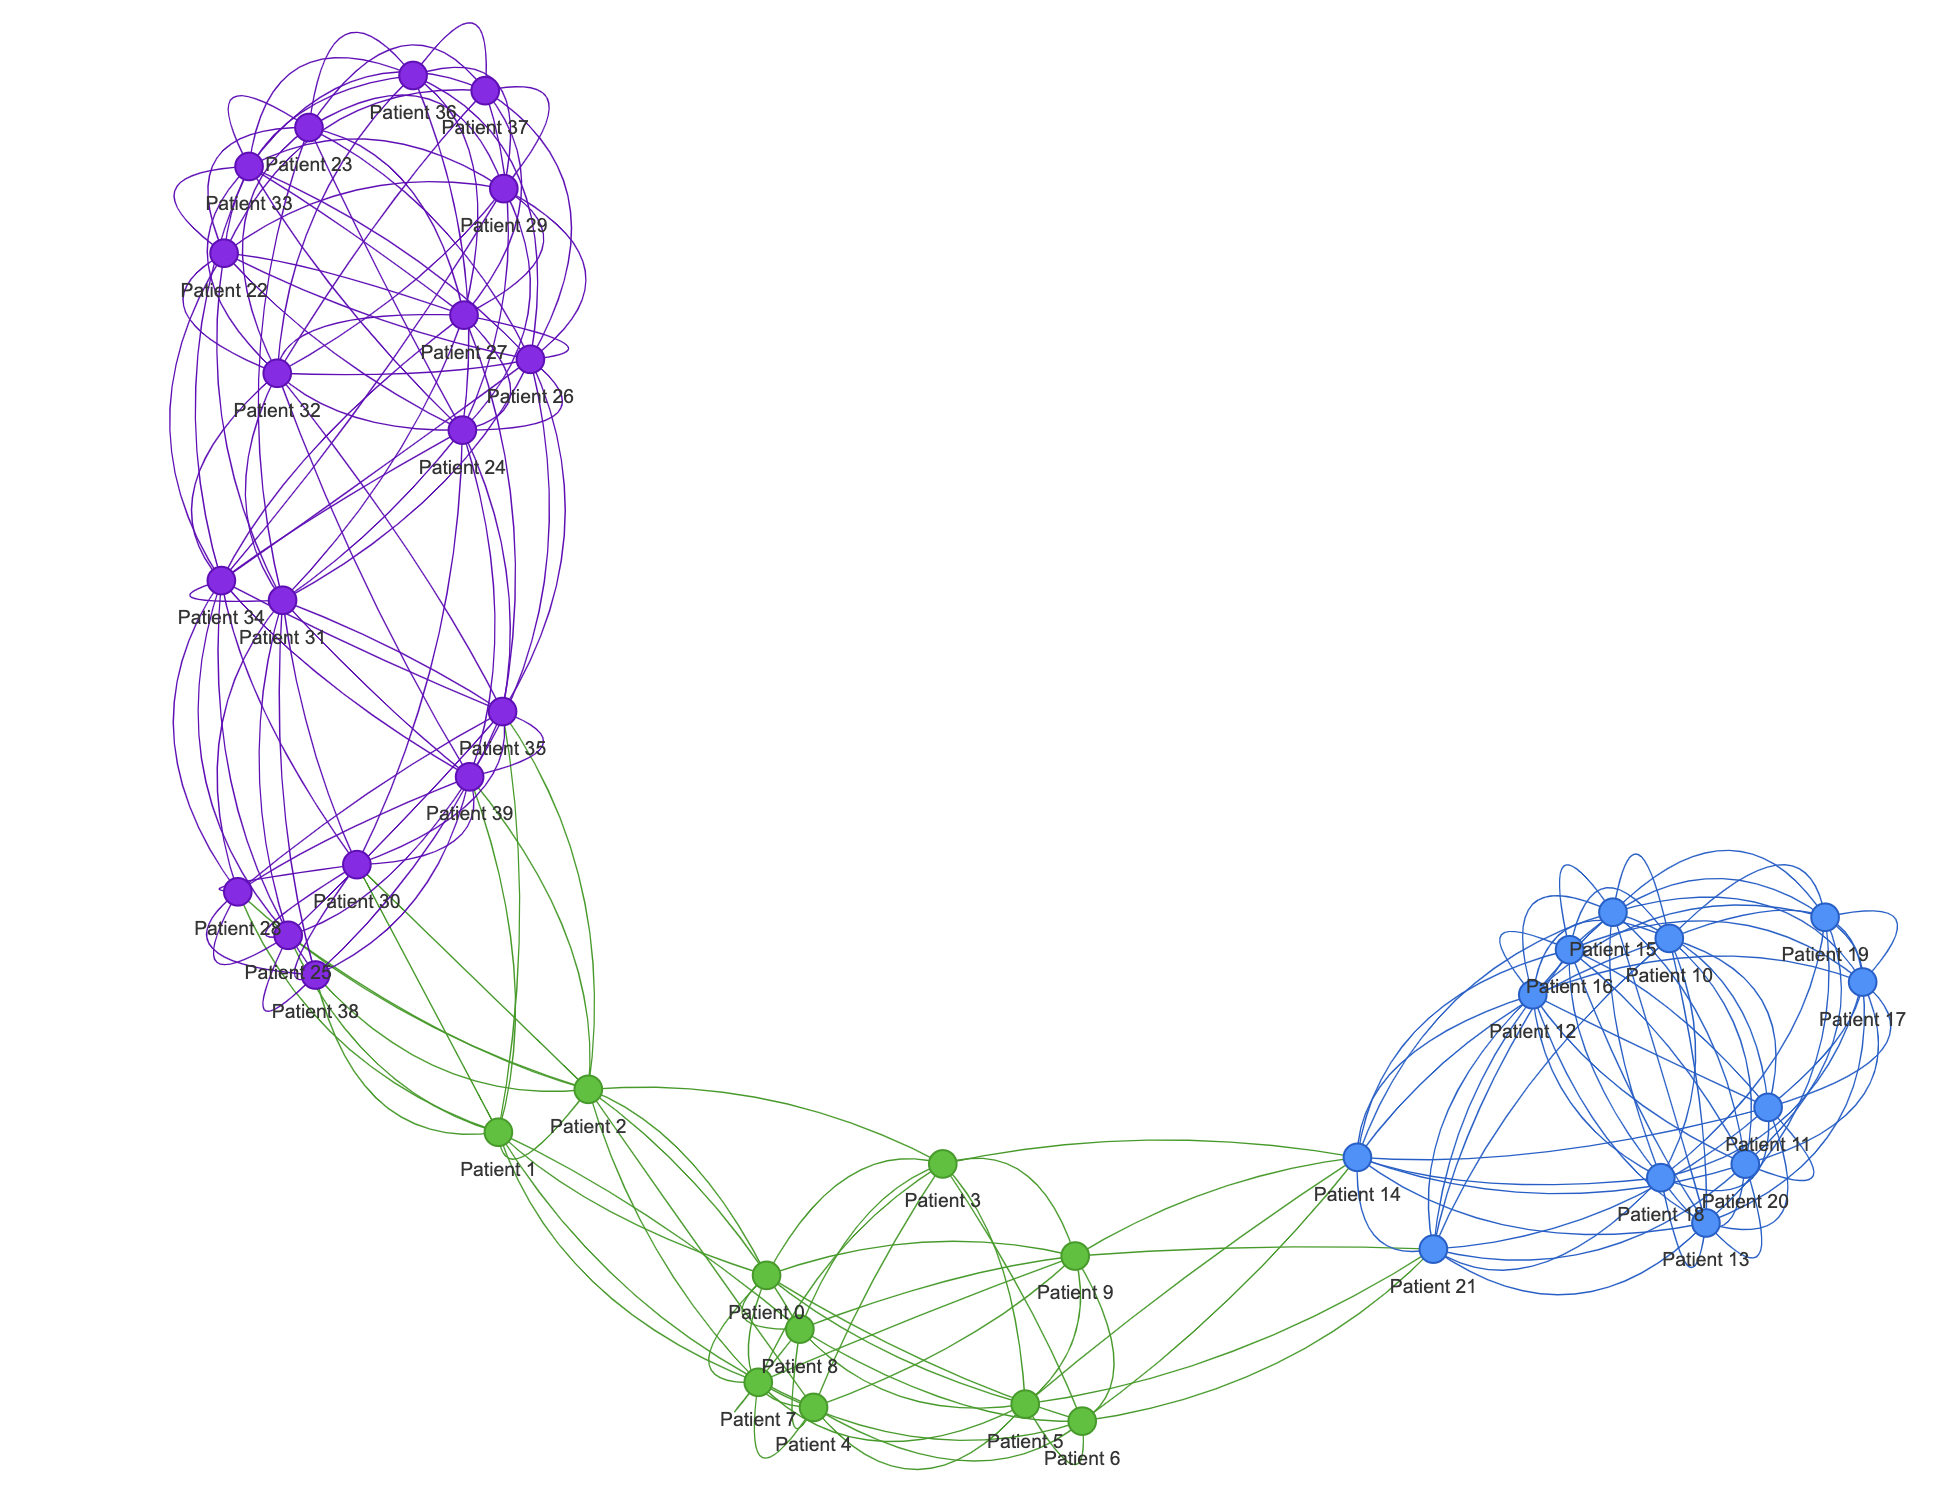

### Third step - Compute scoring and create recommandations

In [109]:
treatment_id = 1
patient = df_patients.iloc[nss, :]
treatment = df_with_results.iloc[treatment_id,:]
associated_drug = df_drugs.iloc[treatment.drug, :]
deseases_map = {0: 'vagal_discomfort', 1: 'diabetes', 2: 'heart_desease'}

def look_for_recommandations():
    average_diarrhee = {}
    average_fever = {}
    average_efficiency = {}
    cpt = {}
    disease = treatment_local.disease
    for i in range(df_with_results.shape[0]):
        treatment_local = df_with_results.iloc[i,:]
        if(disease == treatment.disease):
            cpt[disease] += 1
            average_diarrhee[disease] += treatment.diarrhea_scoring
            average_fever[disease] += treatment.fever_scoring
            average_efficiency[disease] += treatment.scoring
    if (cpt == 0):
        return(0,0,0)
    return(average_diarrhee/cpt, average_fever/cpt, average_efficiency/cpt)

def print_recommandationprint():
    print('#########')
    print('Among the nearest neightbors...')
    print('\n')
    best_drug = ''
    best_efficiency = 0
    average_diarrhee, average_fever, average_efficiency = look_for_recommandations()
    for key in average_diarrhee.keys():
        if average_efficiency[key] > best_efficiency:
            best_drug = key
            best_efficiency = average_efficiency[key]
        print('\033[4m'+key +'\033[0m')
        print("Average efficiency: " + average_efficiency[key])
        print("Side effects: fever (" + str(average_fever[key]*100) + "%), diarrhea ("+ str(average_fever[key]*100) + "%)")
        print('\n')
    print('\n')
    print("Recommandation for patient: \033[4mparacetamol\033[0m")

#########
Among the nearest neightboors...


Aspirine.
Average efficiency: 73%
Side effects: fever (18%), diarrhea (0%)


Paracetamol.
Average efficiency: 84%
Side effects: fever (10%), diarrhea (0%)


Recommandation for patient: paracetamol
